# Time Series Analysis using Machine Learning

## Acknowledgment

This machine learning experiment is inspired by Usman Malik's Stack Abuse article.

You can check out the original post at https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python



## 1. Training a time series predictor

A time series data is a sequential data indexed in time order.
Often we would like to predict the future behaviour of a time series.
For example, we may be interested in predicting the weather, share prices, sales, etc. 
Long Short-Term Memory (LSTM) model can be applied to perform time series prediction. 

In this exercise, we will use the ``daily stock price`` dataset downloaded from yahoo finance.

We will do the following steps in order:

1) Load and normalize the training and testing datasets
   
2) Define an LSTM model

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1.1 Loading the stock index dataset


Loading the  data and convert it to pandas dataframe.
Choose the index name to be ``STI``; ``GSPC``; ``FTSE``.
We have finished three indexes predictions, but in this code we will only show STI index analysis. 

For training data, we used the data before Jun 2022, which is around 604 days (varies for different countries). For testing (validation) data, we used Jun - Aug 2022, which is around 63 days.

In [23]:
index_name = "STI"

In [28]:
df = pd.read_csv(index_name+'_day_Oct31.csv')
df['ref.date'] = pd.to_datetime(df['ref.date'])  
date_start_test = "2022-06-01"
date_end_test = "2022-08-31"
df_train = df[df['ref.date'] < date_start_test]
df_test = df[(df['ref.date'] > date_start_test) & (df['ref.date'] <= date_end_test)]

#print(STI_df_train.to_string())

In [29]:
df_test.head()

,price.open,price.high,price.low,price.close,volume,price.adjusted,ref.date,ticker,ret.adjusted.prices,ret.closing.prices
605,3233.050049,3243.760010,3217.750000,3226.719971,205403300,3226.719971,2022-06-02,^STI,-0.005327,-0.005327
606,3236.699951,3245.179932,3224.889893,3231.969971,160293200,3231.969971,2022-06-03,^STI,0.001627,0.001627
607,3228.469971,3233.959961,3216.120117,3226.629883,183523100,3226.629883,2022-06-06,^STI,-0.001652,-0.001652
608,3224.459961,3231.540039,3214.340088,3231.540039,206133800,3231.540039,2022-06-07,^STI,0.001522,0.001522
609,3233.989990,3241.800049,3220.669922,3225.800049,217125900,3225.800049,2022-06-08,^STI,-0.001776,-0.001776



### 1.2 Visualizing the training data


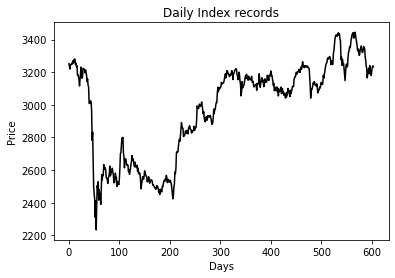

In [32]:
plt.plot(df_train['price.close'], 'k')
plt.title('Daily Index records')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [33]:
daily_returns = df_train['price.close'].pct_change()
print(daily_returns)

0           NaN
1     -0.004053
2     -0.006163
3      0.009009
4     -0.000607
         ...   
599   -0.004839
600    0.009309
601    0.006659
602    0.002591
603   -0.001985
Name: price.close, Length: 604, dtype: float64


### We will decide the shape for train and test data

In [86]:
df_train.shape #604 days for train and 63 days for test
#df_test.shape

(604, 10)

### 1.3 Normalizing the data and converting to tensor

In a regression problem such as this, it is beneficial to normalize the data to (0,1). It allows the model to converge faster and avoid having large losses. 

In [123]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

normalized_data=np.array(NormalizeData(index_day)).reshape(-1,1)

In [124]:
print(normalized_data)

[[0.84068904]
 [0.82981029]
 [0.81333529]
 [0.83727196]
 [0.83564574]
 [0.83695821]
 [0.84394934]
 [0.83992147]
 [0.85599204]
 [0.84479953]
 [0.86214951]
 [0.8646505 ]
 [0.86387467]
 [0.83670228]
 [0.84228201]
 [0.82629407]
 [0.83080074]
 [0.78229181]
 [0.7833814 ]
 [0.77356725]
 [0.75957671]
 [0.72869022]
 [0.76192093]
 [0.79787531]
 [0.8238096 ]
 [0.78248164]
 [0.76735194]
 [0.77760358]
 [0.81705786]
 [0.81435052]
 [0.81430095]
 [0.80849834]
 [0.7949864 ]
 [0.80908435]
 [0.79667852]
 [0.78211025]
 [0.7500598 ]
 [0.76329929]
 [0.72968892]
 [0.72488502]
 [0.64183312]
 [0.63905968]
 [0.64883252]
 [0.65334744]
 [0.64776772]
 [0.60048037]
 [0.45305533]
 [0.49446571]
 [0.36743614]
 [0.21649487]
 [0.18245528]
 [0.15859296]
 [0.06398522]
 [0.14631087]
 [0.        ]
 [0.10612207]
 [0.22450124]
 [0.20971835]
 [0.2437249 ]
 [0.15085058]
 [0.20449349]
 [0.17068503]
 [0.18121717]
 [0.12860602]
 [0.19571129]
 [0.27932441]
 [0.25254014]
 [0.27885408]
 [0.27549463]
 [0.33106079]
 [0.30711585]
 [0.31

### 1.4 Generating the sequences
We deine the text size to be 63 since there are 604 training data and 63 testing data. 
Then we define the window size to be 200. (modified for a better fitting results)

In [125]:
# create windowed sequence tuples of (x,y), with moving window of step size = 1
def windowed_sequences(data, window_size, test_size):
    x = []
    y = []
    for i in range(len(data)-window_size-test_size+1):
        j = i + window_size
        xi = data[i:j]
        yi = data[j]
        x.append(xi)
        y.append(yi)
    return x, y
        
test_size = 63
seqeunces, targets = windowed_sequences(normalized_data, 200, test_size)

 # Convert the sequences to float type tensors
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float) 
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### 1.5 Constructing the iterables

In [126]:
# Using pytorch data loading utility to construct iterable over the dataset

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item],  self.y[item]

    def __len__(self): 
        return len(self.x)
    
train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=200)

### 1.6 Defining the LSTM model

Since we only have 1 input and 1 output value which is the number of passengers, we set the input dimension (input_dim) and output dimension (output_dim) as 1.
hidden_dim defines the number of features in the hidden state of the LSTM.

In [127]:
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=1):
        super(TimeSeriesPredictor,self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, self.hidden_dim,
                            batch_first=True)
                
        self.fc1 = nn.Linear(self.hidden_dim, 100)
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, input_seq):

        lstm_out, (hn, cn) = self.lstm(input_seq)
        predictions = F.relu(self.fc1(hn.view(-1, self.hidden_dim)))
        predictions = self.fc2(predictions)
        return predictions
    
model = TimeSeriesPredictor()

### 1.7 Printing the network structure

In [128]:
print(model)

TimeSeriesPredictor(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### 1.8 Using Torchinfo to view a summary of the network parameters

In [129]:
from torchinfo import summary
summary(model) # (batch_size, sequence_length, input_dim)

Layer (type:depth-idx)                   Param #
TimeSeriesPredictor                      --
├─LSTM: 1-1                              162,400
├─Linear: 1-2                            20,100
├─Linear: 1-3                            101
Total params: 182,601
Trainable params: 182,601
Non-trainable params: 0

### 1.9 Defining loss function and optimizer

The loss function is defined as Mean Squared Error loss and optimizer is Adam optimizer. 



In [130]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### 1.10 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [131]:
model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.0066
epoch: 200 loss: 0.0048
epoch: 300 loss: 0.0040
epoch: 400 loss: 0.0035
epoch: 500 loss: 0.0028
epoch: 600 loss: 0.0019
epoch: 700 loss: 0.0017
epoch: 800 loss: 0.0016
epoch: 900 loss: 0.0015
epoch: 1000 loss: 0.0013
Finished Training
Training time:1786.8040471076965


## 2. Plotting of loss function

In the previous cell, we have saved the loss function at different iterations in the loss_list.

Now, plot the loss function versus the iteration number using matplotlib.

### 2.1 Plotting the loss function vs interation number

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

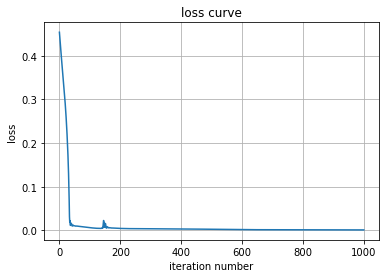

In [133]:
# Plot the training loss curve
# To do
t = np.arange(0, 1000, 1)
s = loss_list

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='iteration number', ylabel='loss',
       title='loss curve')
ax.grid()

plt.show()

### 2.2 Evaluating network performance on the test data

We have trained the network for several passes over the training dataset.
But we need to check if the network has learned anything at all.

We will check this by predicting the next time-step value that the neural network
outputs, and checking it against the ground truth.



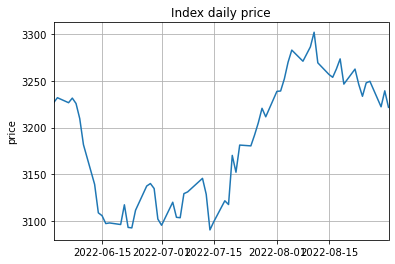

In [63]:
plt.title('Index daily price')
plt.ylabel('price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df_test['ref.date'], df_test['price.close'])
plt.show()

### 2.3 Perform predictions using the trained model



In [134]:
preds_63 = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-63:]
        preds_63.append(outputs)

## 3. Evaluating network performance 

In this section, we are going to evaluate the accuracy of the model in predicting future values. Since we are predicting more than 1 value, we will use the Mean Absolute Percentage Error (MAPE) to measure the difference between the predicted value and the ground truth value. 

### 3.1 Computing MAPE

Calculate the MAPE for future daily predictions. They can be computed using API from scikit-learn:

MAPE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

In [138]:
from sklearn.metrics import mean_absolute_percentage_error

#denormalized_preds_63 = scaler.inverse_transform(np.array(preds_63).reshape(-1, 1))
def denormalizeData(data,ori_data):
    return data*(np.max(ori_data) - np.min(ori_data))+np.min(ori_data)

denormalized_preds_63=denormalizeData(np.array(preds_63).reshape(-1,1),index_day)
# To do
mape = mean_absolute_percentage_error(df_test['price.close'], denormalized_preds_63)

print('MAPE: %.2f%%' % (mape*100))

MAPE: 1.68%


/var/folders/fs/_b0ck_9j47166mrp6xyj8hbr0000gn/T/ipykernel_94611/3434910355.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  denormalized_preds_63=denormalizeData(np.array(preds_63).reshape(-1,1),index_day)
/var/folders/fs/_b0ck_9j47166mrp6xyj8hbr0000gn/T/ipykernel_94611/3434910355.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  denormalized_preds_63=denormal

### 3.2 Plotting the predictions against the data

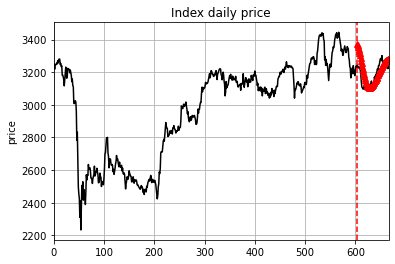

In [149]:
x_axis = np.arange(604, 667, 1)
plt.title('Index daily price')
plt.ylabel('price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['price.close'][0:667], 'k')
plt.plot(x_axis,denormalized_preds_63, 'r^--', label='seq_len_12')
plt.axvline(x=604, color='r', linestyle='--')
plt.savefig('prediction_with_train.jpg')
plt.show()

### 3.3 Zoom in to the predictions

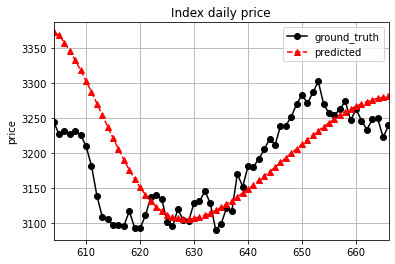

In [145]:
x_axis = np.arange(604, 667, 1)
plt.title('Index daily price')
plt.ylabel('price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,df['price.close'][604:667], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_63, 'r^--', label='predicted')
plt.legend()
plt.savefig('prediction.jpg')
plt.show()